In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kruskal
import tifffile as tf
import math
import matplotlib as mpl
from statsmodels.stats.multitest import multipletests
import csv

In [2]:
file_folder_list_ach_1 = ['20230417-nsyb-G7f-rAch1h/fly2',
                        '20230420-nsyb-G7f-rAch1h/fly2',
                        '20230420-nsyb-G7f-rAch1h/fly3',
                        '20230428-nsyb-G7f-rAch1h/fly1',
                        '20230507-nsyb-G7f-rAch1h/fly1',
                        '20230510-nsyb-G7f-rAch1h/fly1',
                        '20230510-nsyb-G7f-rAch1h/fly2',
                        '20230511-nsyb-G7f-rAch1h/fly2',
                        '20230511-nsyb-G7f-rAch1h/fly3',
                        '20230515-nsyb-G7f-rAch1h/fly1']
file_folder_list_ach_2 = ['20230417-fly2', '20230420-fly2', '20230420-fly3', '20230428-fly1', 
                 '20230507-fly1', '20230510-fly1', '20230510-fly2', '20230511-fly2', '20230511-fly3', '20230515-fly1']
file_folder_list_5ht_1 = ['20230429-nsyb-G7f-r5HT1.0/fly1',
                        '20230506-nsyb-G7f-r5HT1.0/fly1',
                        '20230513-nsyb-G7f-r5HT1.0/fly1',
                        '20230513-nsyb-G7f-r5HT1.0/fly2',
                        '20230516-nsyb-G7f-r5HT1.0/fly2',
                        '20230516-nsyb-G7f-r5HT1.0/fly4',
                        '20230517-nsyb-G7f-r5HT1.0/fly1',
                        '20230601-nsyb-G7f-r5HT1.0/fly1',
                        '20230601-nsyb-G7f-r5HT1.0/fly3',
                        '20230603-nsyb-G7f-r5HT1.0/fly1']
file_folder_list_5ht_2 = ['20230429-r5HT1.0-fly1', '20230506-r5HT1.0-fly1', '20230513-r5HT1.0-fly1', '20230513-r5HT1.0-fly2', 
                '20230516-r5HT1.0-fly2', '20230516-r5HT1.0-fly4', '20230517-r5HT1.0-fly1', '20230601-r5HT1.0-fly1', 
                '20230601-r5HT1.0-fly3', '20230603-r5HT1.0-fly1']

In [3]:
# choose the variable, channel, odor
# the flag_name changes with filename
filename = 'acc' # acc / auc_weighted / precision_weighted / recall_weighted / f1_weighted
channel_selected = [1,2] # 1-G7f, 2-NM, 0-Both
odor_selected = 0
y_chance = 33
flag_name = 'Accuracy' 

# only left part
br_index = [64,65,66,55,72,73,74,63,84,59,4,23,26,56,79,75,76,77,60,80,82,85,67]
br_name = ['MBPED','MBVL','MBML','LH','SLP','SIP','SMP','CRE','SCL','ICL',
'NO','EB','FB','LAL','AOTU','AVLP','PVLP','IVLP','VES','GOR','SPS','EPA','FLA']
br_olf = np.array([1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
print(len(br_index))
print(len(br_name))
print(len(br_olf))

# parameters
atlas_z_range = range(13,38)
win_x = 4
win_y = 4
win_z = 2
if_save = True
if_p_corr = False
num_channel_choice = 3
num_odor_choice = 4

23
23
23


In [4]:
# load Ach data
result_path = '../results/nsyb-G7f-rAch1h'
sub_path = 'Accuracy_map_DEEPCAD_formal'
atlas_path = '../../data'
atlas_file_name = 'align_to_atlas/Transformed_atlas_eroded_r5.tif'
list_fly = [0,1,2,3,4,5,6,7,8,9]###### choose fly
LH_none = [4]
num_fly = len(list_fly)

figure_save_path = '../../' + 'figures-revision-1'
folder = os.path.exists(figure_save_path)
if not folder:
    os.makedirs(figure_save_path)

# compute 
list_acc_ach = np.zeros((num_fly,len(br_index),num_channel_choice,num_odor_choice))
for i,id in enumerate(list_fly):
    # load map
    the_path = result_path + '/' + file_folder_list_ach_2[id] + '/' + sub_path + '/' + filename + '.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    # print(np.shape(a))

    # load atlas
    the_atlas_path = atlas_path + '/' + file_folder_list_ach_1[id] + '/' + atlas_file_name
    atlas= tf.imread(the_atlas_path)
    atlas = np.transpose(atlas,[1,2,0])
    atlas = atlas[:,:,atlas_z_range]
    atlas = atlas[range(int(win_x/2),np.size(atlas,0),win_x),:,:]
    atlas = atlas[:,range(int(win_y/2),np.size(atlas,1),win_y),:]
    atlas = atlas[:,:,range(0,np.size(atlas,2),win_z)]
    # print('load atlas done! size:')
    # print(np.shape(atlas))

    for j,index in enumerate(br_index):
        if j==3 and i in LH_none:
            continue
        mask = atlas == index
        if np.sum(mask)>0:
            flag = a[:,:,mask]
            if flag.ndim==3:
                data = np.mean(flag,2)
            elif flag.ndim==2:
                data = flag 
            if num_odor_choice == 1:
                list_acc_ach[i,j,:,0] = np.squeeze(data)
            else:
                list_acc_ach[i,j,:,:] = data

list_acc_ach_selected = np.squeeze(list_acc_ach[:,:,channel_selected,odor_selected])
list_acc_ach_selected = list_acc_ach_selected*100

In [5]:
# load 5HT data
result_path = '../results/nsyb-G7f-r5HT1.0'
sub_path = 'Accuracy_map_DEEPCAD_formal'
atlas_path = result_path
atlas_path = '../../data'
list_fly = [0,1,2,3,4,5,6,7,8,9]###### choose fly
LH_none = [7]
num_fly = len(list_fly)

# compute 
list_acc_5ht = np.zeros((num_fly,len(br_index),num_channel_choice,num_odor_choice))
for i,id in enumerate(list_fly):
    # load map
    the_path = result_path + '/' + file_folder_list_5ht_2[id] + '/' + sub_path + '/' + filename + '.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    # print(np.shape(a))

    # load atlas
    the_atlas_path = atlas_path + '/' + file_folder_list_5ht_1[id] + '/' + atlas_file_name
    atlas= tf.imread(the_atlas_path)
    atlas = np.transpose(atlas,[1,2,0])
    atlas = atlas[:,:,atlas_z_range]
    atlas = atlas[range(int(win_x/2),np.size(atlas,0),win_x),:,:]
    atlas = atlas[:,range(int(win_y/2),np.size(atlas,1),win_y),:]
    atlas = atlas[:,:,range(0,np.size(atlas,2),win_z)]
    # print('load atlas done! size:')
    # print(np.shape(atlas))

    for j,index in enumerate(br_index):
        if j==3 and i in LH_none:
            continue
        mask = atlas == index
        if np.sum(mask)>0:
            flag = a[:,:,mask]
            if flag.ndim==3:
                data = np.mean(flag,2)
            elif flag.ndim==2:
                data = flag 
            if num_odor_choice == 1:
                list_acc_5ht[i,j,:,0] = np.squeeze(data)
            else:
                list_acc_5ht[i,j,:,:] = data

list_acc_5ht_selected = np.squeeze(list_acc_5ht[:,:,channel_selected,odor_selected])
list_acc_5ht_selected = list_acc_5ht_selected*100

In [6]:
print(np.shape(list_acc_ach_selected))
print(np.shape(list_acc_5ht_selected))

(10, 23, 2)
(10, 23, 2)


In [7]:
# integrate the data
list_acc_g7f = np.concatenate((np.squeeze(list_acc_ach_selected[:,:,0]),np.squeeze(list_acc_5ht_selected[:,:,0])),axis = 0)
list_acc_ach = np.squeeze(list_acc_ach_selected[:,:,1])
list_acc_5ht = np.squeeze(list_acc_5ht_selected[:,:,1])
print(np.shape(list_acc_g7f))
print(np.shape(list_acc_ach))
print(np.shape(list_acc_5ht))

(20, 23)
(10, 23)
(10, 23)


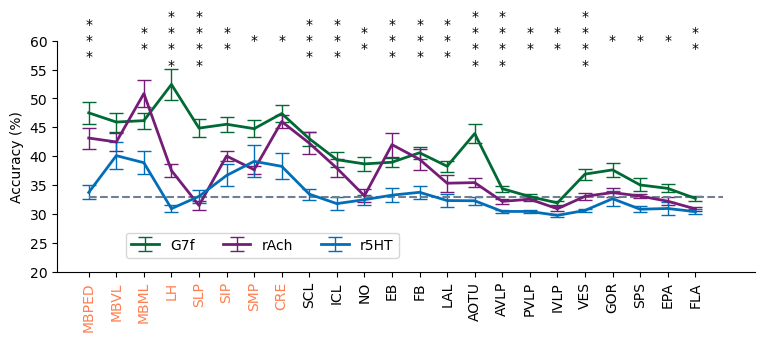

In [8]:
plt.figure(figsize = (9,3))
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
color_list = ['#006934','#751C77','#036EB8']
labels = ['G7f','rAch','r5HT']
p_result = []
# plot g7f
the_mean_g7f = np.zeros(len(br_index))
the_std_g7f = np.zeros(len(br_index))
for i in range(len(br_index)):
    a = list_acc_g7f[:,i]
    a = a[a!=0]
    the_mean_g7f[i] = np.mean(a,0)
    the_std_g7f[i] = np.std(a,ddof = 1)/math.sqrt(len(a))
plt.errorbar(range(len(br_index)),the_mean_g7f,yerr=the_std_g7f,ecolor=color_list[0],elinewidth=1,marker='.',mfc=color_list[0],\
mec=color_list[0],mew=1,ms=1,alpha=1,capsize=5,capthick=3,color=color_list[0], linewidth=2,label = labels[0])

# plot ach
the_mean_ach = np.zeros(len(br_index))
the_std_ach = np.zeros(len(br_index))
for i in range(len(br_index)):
    a = list_acc_ach[:,i]
    a = a[a!=0]
    the_mean_ach[i] = np.mean(a,0)
    the_std_ach[i] = np.std(a,ddof = 1)/math.sqrt(len(a))
plt.errorbar(range(len(br_index)),the_mean_ach,yerr=the_std_ach,ecolor=color_list[1],elinewidth=1,marker='.',mfc=color_list[1],\
mec=color_list[1],mew=1,ms=1,alpha=1,capsize=5,capthick=3,color=color_list[1], linewidth=2,label = labels[1])

# plot 5ht
the_mean_5ht = np.zeros(len(br_index))
the_std_5ht = np.zeros(len(br_index))
for i in range(len(br_index)):
    a = list_acc_5ht[:,i]
    a = a[a!=0]
    the_mean_5ht[i] = np.mean(a,0)
    the_std_5ht[i] = np.std(a,ddof = 1)/math.sqrt(len(a))
plt.errorbar(range(len(br_index)),the_mean_5ht,yerr=the_std_5ht,ecolor=color_list[2],elinewidth=1,marker='.',mfc=color_list[0],\
mec=color_list[2],mew=1,ms=1,alpha=1,capsize=5,capthick=3,color=color_list[2], linewidth=2,label = labels[2])
plt.ylim((20,60))
plt.ylabel((flag_name + ' (%)'))
plt.xticks(range(len(br_index)),br_name,rotation=90)
plt.legend(bbox_to_anchor=(0.5, 0.03),loc=4,ncol=3)
for j in range(len(br_index)):
    if br_olf[j]==1:
        plt.gca().get_xticklabels()[j].set_color('coral') 

# *
p_list = []
for i in range(len(br_index)):
    a = list_acc_g7f[:,i]
    a = a[a!=0]
    b = list_acc_ach[:,i]
    b = b[b!=0]
    c = list_acc_5ht[:,i]
    c = c[c!=0]
    y = 60
    res = kruskal(a,b,c)
    p = res.pvalue
    p_list.append(p)

if if_p_corr:
    p_corrected = multipletests(p_list)
    p_list = p_corrected[1]
for i in range(len(p_list)):
    p = p_list[i]
    if p<0.05 and p>=0.01:
        plt.text(i,y,'*',verticalalignment = 'center', horizontalalignment = 'center')
    elif p<0.01 and p>0.001:
        plt.text(i,y,'*\n*',verticalalignment = 'center', horizontalalignment = 'center')
    elif p<0.001 and p>=0.0001:
        plt.text(i,y,'*\n*\n*',verticalalignment = 'center', horizontalalignment = 'center') 
    elif p<0.0001:
        plt.text(i,y,'*\n*\n*\n*',verticalalignment = 'center', horizontalalignment = 'center') 
p_result.append(p_list)
plt.plot([0,len(br_name)],[y_chance,y_chance],color = 'slategray',linestyle='--')

if if_save:
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    plt.savefig(figure_save_path + '/' + '3b_accuracy_map_region_' + filename + '_odor'+str(odor_selected)+'-bar-hor.pdf',dpi = 300,bbox_inches = 'tight')
    plt.savefig(figure_save_path + '/' + '3b_accuracy_map_region_' + filename + '_odor'+str(odor_selected)+'-bar-hor.png',dpi = 300,bbox_inches = 'tight')
    with open(figure_save_path + '/' + '3b_accuracy_map_region_' + filename + '_odor'+str(odor_selected)+'-p.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(p_result)
plt.show()